In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import regex

from tqdm import tqdm

In [2]:
from src import utils,physics
from src.density.nfw import NFW
from src.density.hernquist import Hernquist
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.background import Mass_Distribution
from src.constants import G,Msun,kpc,Myr,Gyr,cross_section,km,second

# Constants and general functions

In [3]:
# Mtot = 1.0e10 * Msun #Default halo mass in solar masses (Msun).
# Rs = 2.68441 * kpc #kpc
# c = 17
Mtot_dm = 1.15e9 * Msun
Mtot_b = 1e5 * Msun
Rs = 1.18 * kpc
c = 19
sigma = 50 * cross_section
# sigma = 0

# Setup - DM

In [4]:
n_particles = int(1e5)
density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,unit_mass=Mtot_dm/n_particles)
steps_per_Tdyn = 1000
total_run_time = 61 * density.Tdyn
save_every = 1*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=sigma,save_every=save_every,
                  total_run_time=total_run_time)

In [5]:
# halo.reset()
# halo.evolve(n_Tdyn=1100)
halo.evolve(n_Tdyn=61)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

100%|████████████████████████████████████████████████████████████████| 61000/61000 [15:03<00:00, 67.52it/s]


In [6]:
halo.saved_states.to_csv('states dm.csv')

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

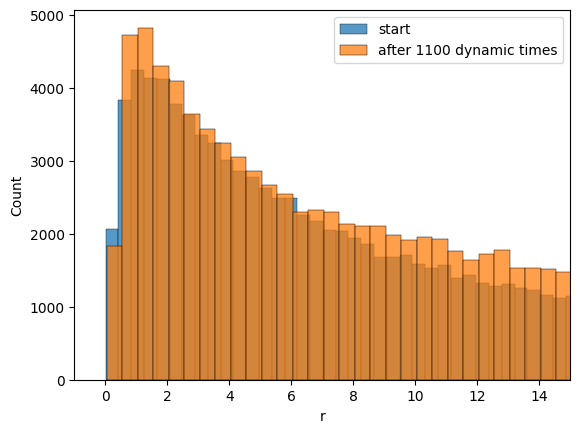

In [7]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)
ax.set_xlim((-1,15))
ax.legend(['start','after 1100 dynamic times'])

In [12]:
data = halo.saved_states.copy();
data = data[data['r'] < 1*kpc].copy()

In [21]:
data

,particle_index,r,vx,vy,vr,vp,v_norm,live,step,time,output
3,3,0.307569,-0.001311,0.012748,-0.007333,0.012815,0.014765,True,0,0.000000,0.307569
28,28,0.963075,0.000512,0.011019,0.030809,0.011031,0.032724,True,0,0.000000,0.963075
49,49,0.709391,-0.008025,-0.009547,-0.003675,0.012472,0.013002,True,0,0.000000,0.709391
58,58,0.356223,0.006558,0.005517,-0.007885,0.008570,0.011646,True,0,0.000000,0.356223
71,71,0.701970,0.005548,0.000092,-0.000493,0.005549,0.005571,True,0,0.000000,0.701970
...,...,...,...,...,...,...,...,...,...,...,...
6006136,91809,0.999356,-0.004952,0.002710,-0.005872,0.005645,0.008145,True,60000,1070.022226,0.999356
6006137,61781,0.999512,-0.010153,-0.004766,0.000584,0.011216,0.011231,True,60000,1070.022226,0.999512
6006138,97121,0.999345,-0.005608,0.014844,-0.015136,0.015868,0.021929,True,60000,1070.022226,0.999345
6006139,61264,0.999911,0.003100,0.006028,0.009147,0.006779,0.011385,True,60000,1070.022226,0.999911


In [32]:
data[data['step'] == step].time.iloc[0]/110

np.float64(9.72747477927579)

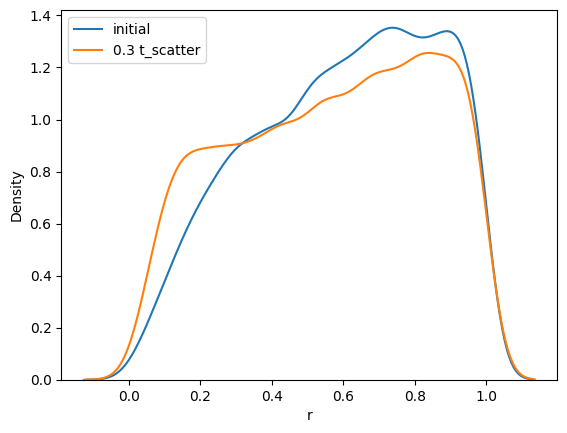

In [45]:
steps = [2000]
time = []
ax = sns.kdeplot(data[data['step'] == 0].r)
for step in steps:
    sns.kdeplot(data[data['step'] == step].r,ax=ax)
    time += [data[data['step'] == step].time.iloc[0]/110]
ax.legend(['initial']+[f'{t:.1f} t_scatter' for t in time])

(<Figure size 600x500 with 2 Axes>,
 <Axes: xlabel='Radius [kpc]', ylabel='Time [Myr]'>)

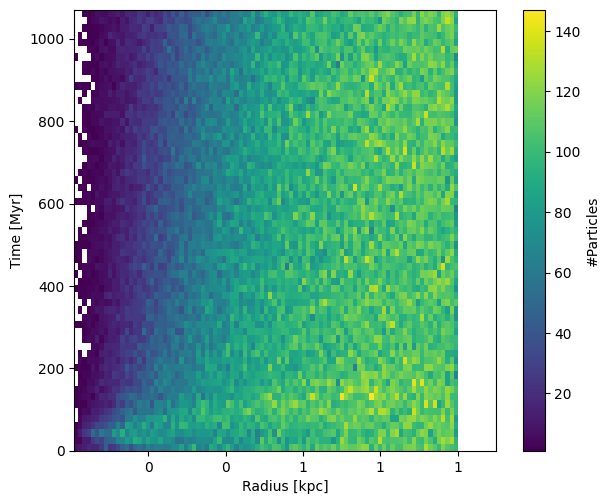

In [16]:
data['output'] = data.r
length_units = {'value':kpc,'name':'kpc'}
time_units = {'name':'Myr','value':Myr}
grid,extent = halo.prep_2d_data(data,radius_cutoff=5,x_units=length_units,time_units=time_units,agg_fn='count')

utils.plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='#Particles')

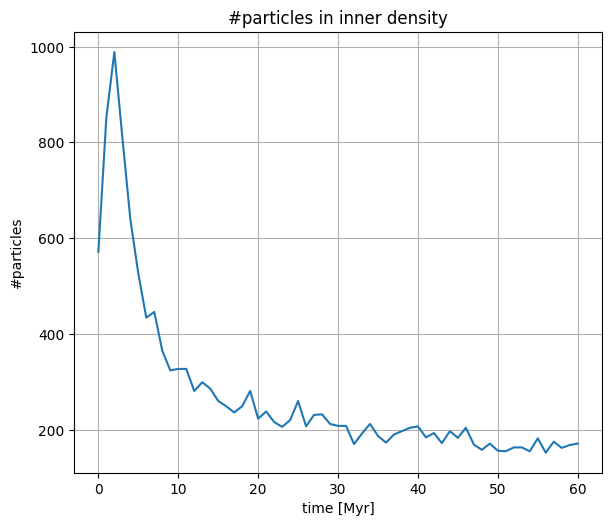

In [8]:
halo.plot_inner_core_density();

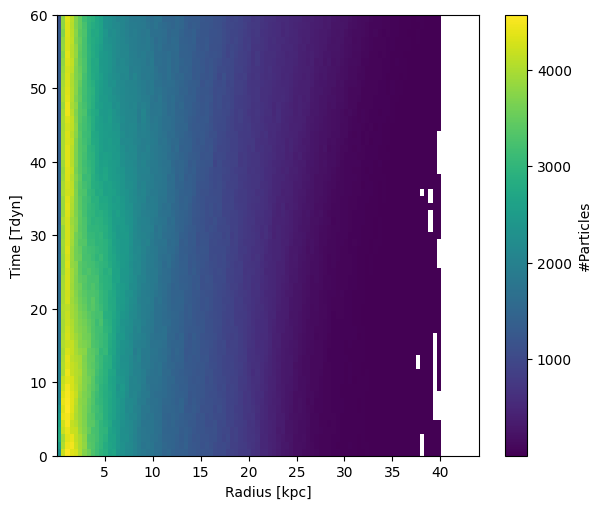

In [9]:
halo.plot_density_evolution();

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'bin'] = lattice.posts[lattice(data.r.to_numpy())]


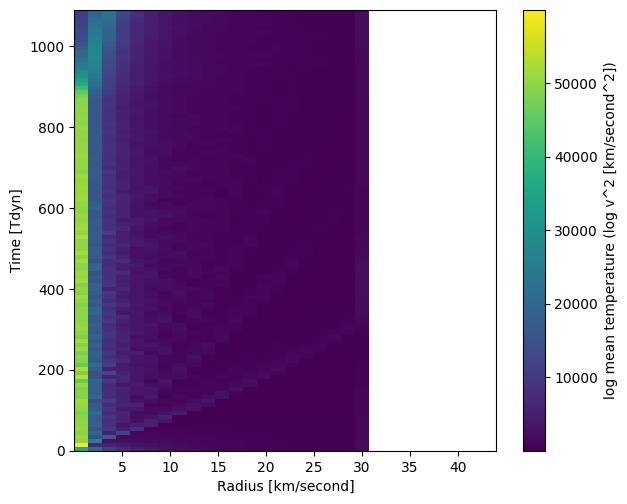

In [8]:
halo.plot_temperature();

# Setup

In [35]:
n_particles = int(1e5)
dm_density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot_dm/n_particles)
density = Hernquist(Mtot=Mtot_b,Rmin=1e-4*kpc,Rmax=85*Rs,unit_mass=Mtot_b/n_particles)
density.Tdyn = dm_density.Tdyn
steps_per_Tdyn = 1000
total_run_time = 1100 * density.Tdyn
save_every = 10*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=0,save_every=save_every,
                  total_run_time=total_run_time,mass_calculation_method='lattice')
halo.add_background(Mass_Distribution.from_files(halo.lattice,Mtot=Mtot_dm,base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12550000,tfinal=1100,
                                                 max_time=19.605*Gyr))

Load files: 100%|██████████████████████████████████████████████████████| 251/251 [00:00<00:00, 1185.87it/s]


In [ ]:
# halo.reset()
halo.evolve(n_Tdyn=1100)
# halo.evolve(n_Tdyn=81)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

In [13]:
halo.saved_states.to_csv('states dm.csv')

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

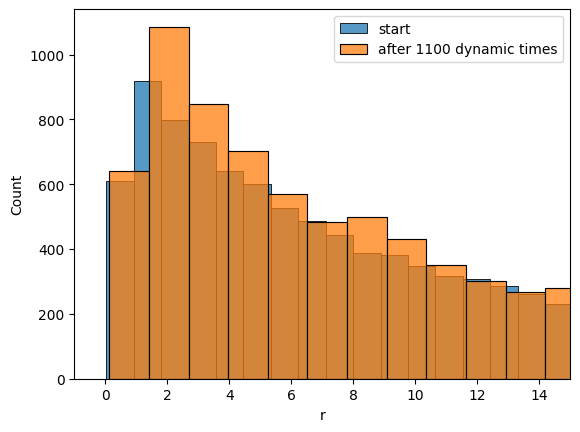

In [14]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)
ax.set_xlim((-1,15))
ax.legend(['start','after 1100 dynamic times'])

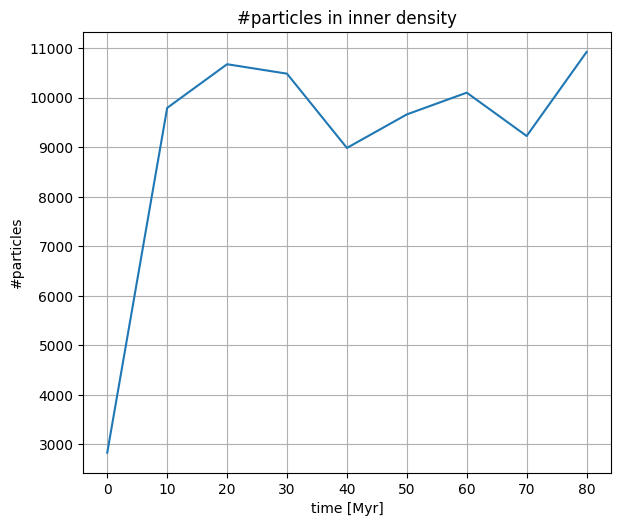

In [21]:
halo.plot_inner_core_density();

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'bin'] = lattice.posts[lattice(data.r.to_numpy())]


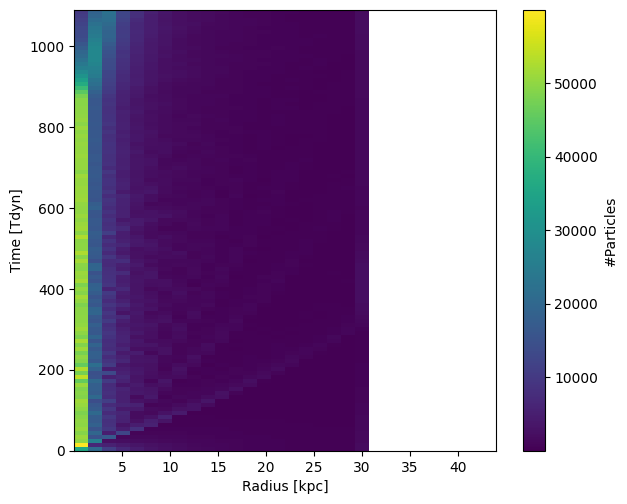

In [7]:
halo.plot_density_evolution();

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'bin'] = lattice.posts[lattice(data.r.to_numpy())]


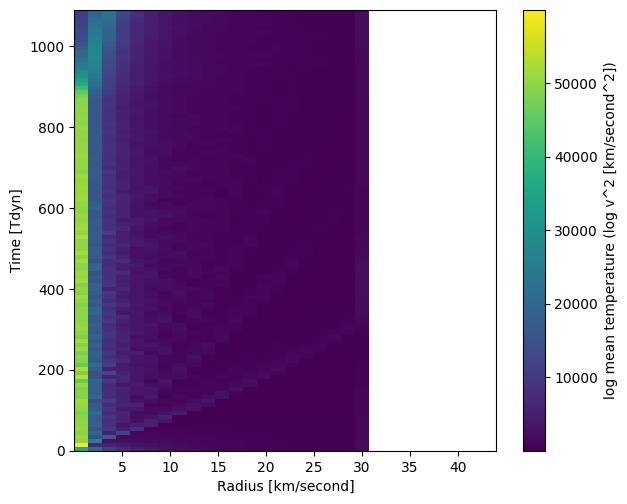

In [8]:
halo.plot_temperature();

# Results:

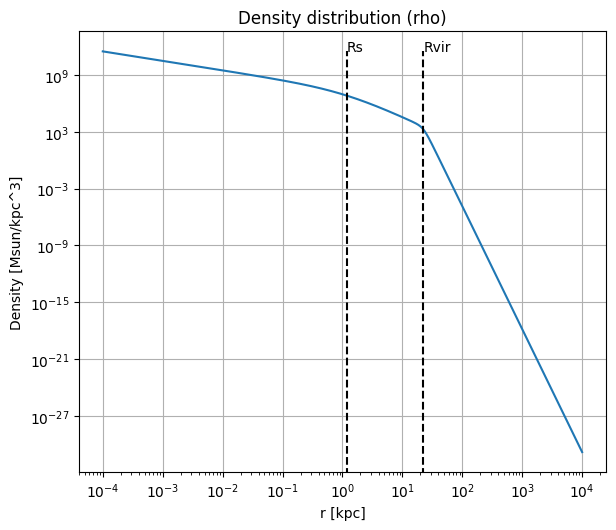

In [5]:
halo.density.plot_rho();

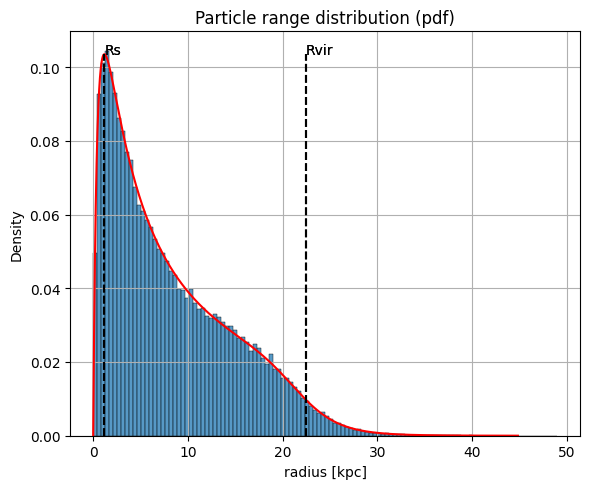

In [5]:
halo.plot_r_distribution(halo.initial_particles,cumulative=False);

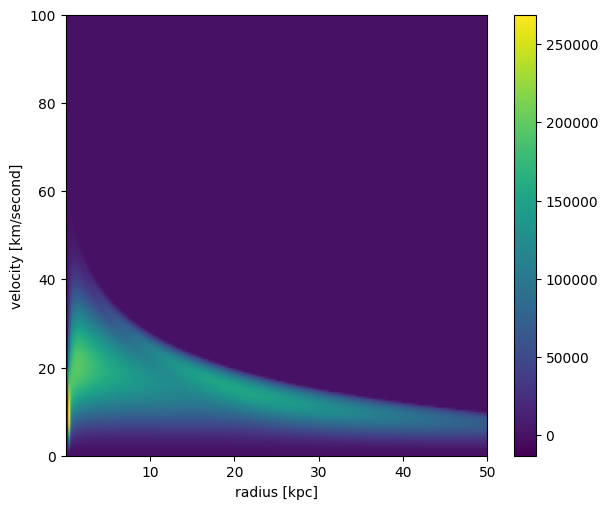

In [9]:
halo.density.plot_phase_space();

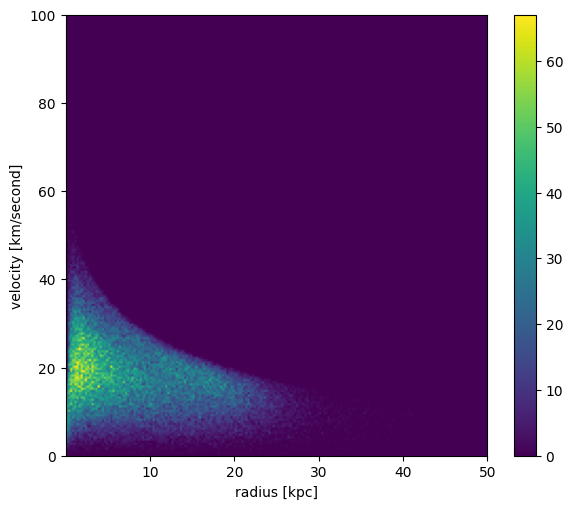

In [10]:
halo.plot_phase_space(halo.initial_particles);